In [1]:
import numpy as np
import pandas as pd

import bofire.strategies.api as strategies
import bofire.surrogates.api as surrogates
from bofire.data_models.acquisition_functions.api import qLogEI
from bofire.data_models.domain.api import Domain, Inputs, Outputs
from bofire.data_models.features.api import (
    ContinuousInput,
    ContinuousOutput,
    TaskInput,
)
from bofire.data_models.objectives.api import MaximizeObjective
from bofire.data_models.strategies.api import SoboStrategy
from bofire.data_models.surrogates.api import BotorchSurrogates, MultiTaskGPSurrogate

/var/folders/6j/glsx_1g54671hs1jf1v0k06h0000gn/T/ipykernel_4172/2446635811.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/josepablofolch/miniconda3/envs/bofire_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/josepablofolch/Documents/Imperial College/Coding Projects/bofire/bofire/strategies/predictives/enting.py:14: UserWarning: entmoot not installed, BoFire's `EntingStrategy` cannot be used.
 

In [2]:
import matplotlib.pyplot as plt

In this notebook show how to use BoFire for the purposes of transfer learning Bayesian optimization. In particular, we assume we have a task $f_2$ with data that is relevant to the optimization of our current task $f_1$. The procedure is simple, we fit a MultiTask GP to both data-sets, however only carry out the BO on $f_1$, i.e., we optimize the acquisition functions on on the task $f_1$.

We build a small data-set using the target task:

$$ f_1(x) = \sin(2 \pi x) $$

And we will have data the second related task:

$$ f_2 = 0.9 \sin(2 \pi x) + 0.2 \cos(3 \pi x) - 0.2 $$

We begin by defining the functions, generating some data, and plotting it. We generate 15 data-points for Task 2 and just 4 data-points for Task 1, all the data-points in Task 1 will be in a restricted area of the space.

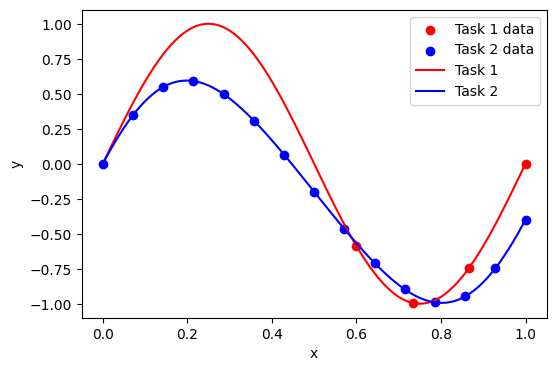

In [3]:
def task_1_f(x):
    return np.sin(x * 2 * np.pi)

def task_2_f(x):
    return 0.9* np.sin(x * 2 * np.pi) - 0.2 + 0.2 * np.cos(x * 3 * np.pi)

x = np.linspace(0, 1, 101)

# generate lots of low fidelity data and a few high fidelity data

task_1_x = np.linspace(0.6, 1, 4)
task_1_y = task_1_f(task_1_x)

task_2_x = np.linspace(0, 1, 15)
task_2_y = task_2_f(task_2_x)

# set the data in the pandas format
experiments = pd.DataFrame({"x": np.concatenate([task_1_x, task_2_x]), "y": np.concatenate([task_1_y, task_2_y]), "task": ["task_1"]*len(task_1_x) + ["task_2"]*len(task_2_x)})

plt.figure(figsize=(6, 4))

plt.scatter(task_1_x, task_1_y, label="Task 1 data", color="red")
plt.scatter(task_2_x, task_2_y, label="Task 2 data", color="blue")

plt.plot(x, task_1_f(x), label="Task 1", color="red")
plt.plot(x, task_2_f(x), label="Task 2", color="blue")

plt.xlabel("x")
plt.ylabel("y")

plt.legend()

We now set-up the model according to BoFire's API. 

We define the set of input and output features and the corresponding bounds, and create a surrogate data model.

In [4]:
# set-up the task model with allowed variable as ["True"] for the target task and ["False"] for the other task
task_input = TaskInput(key = "task", categories=["task_1", "task_2"], allowed=[True, False])
# define the input features
input_features = [ContinuousInput(key = "x", bounds = (0, 1)), task_input]

objective = MaximizeObjective(w = 1)
output_features = [ContinuousOutput(key = "y", objective = objective)]

inputs = Inputs(features = input_features)
outputs = Outputs(features = output_features)

surrogate_data = MultiTaskGPSurrogate(inputs = inputs, outputs = outputs)

We now put the training data in the correct pandas format, map from the surrogate data into the surrogate model and fit the data.

In [5]:
surrogate = surrogates.map(surrogate_data)

surrogate.fit(experiments)

/Users/josepablofolch/miniconda3/envs/bofire_env/lib/python3.12/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708328286453/work/torch/csrc/utils/tensor_new.cpp:623.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


Plot to see how we are able to predict outside of the region where there is data for Task 1, since we can use the data from Task 2 and the learnt correlations:

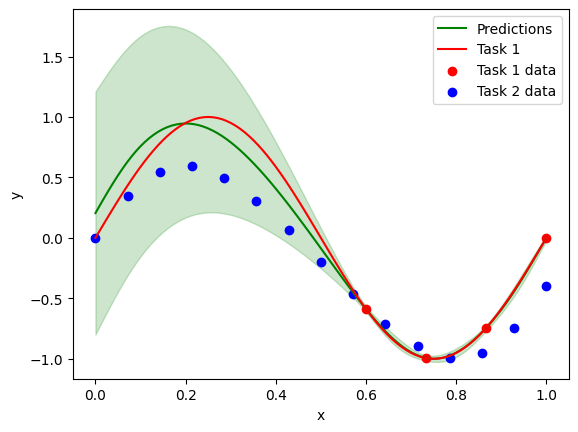

In [6]:
# predict the high fidelity data
x_predict = np.linspace(0, 1, 101)
y_predict = surrogate.predict(pd.DataFrame({"x": x_predict, "task": ["task_1"]*len(x_predict)}))

# plot data and predictions
plt.plot(x_predict, y_predict["y_pred"], label="Predictions", color="green")
plt.fill_between(x_predict, y_predict["y_pred"] - 2 * y_predict["y_sd"], y_predict["y_pred"] + 2 * y_predict["y_sd"], color="green", alpha=0.2)

# plot the high fidelity function
plt.plot(x, task_1_f(x), label="Task 1", color="red")

# plot the data too
plt.scatter(experiments[experiments["task"] == "task_1"]["x"], experiments[experiments["task"] == "task_1"]["y"], label="Task 1 data", color="red")
plt.scatter(experiments[experiments["task"] == "task_2"]["x"], experiments[experiments["task"] == "task_2"]["y"], label="Task 2 data", color="blue")

plt.xlabel("x")
plt.ylabel("y")

plt.legend()

Let us now try to integrate this into BoFire's `SOBO` strategy. I made some minor changes to:

- `TaskInput` allows for a string that can specify an `output_task`, there is a validator that checks if `output_task` is on the categories list.


- Small modifications to `multi_task_gp.py` so that the output task is passed to the BoTorch model if there is one, or defaults to `None`(as in BoTorch).


- Small modification to `bofire/strategies/predictives/botorch.py` because `MultiTaskGP`in BoTorch does not allow for `observation_noise = True` currently, so I had to manually add the likelihood noise.


- Small modification to `bofire/data_models/domain/features.py` in particular to the `inverse_transform` function because sometimes that task-indexes are made into `float` by `torch` at some point, so I just make sure to change the type to `int` before transforming back ordinal encodings.


With just these modifications it appeared to work at first instance:

In [7]:
input_features = [ContinuousInput(key = "x", bounds = (0, 1)),
                TaskInput(key = "task",
                categories=["task_1", "task_2"],
                allowed=[True, False])]

objective = MaximizeObjective(w = 1)
output_features = [ContinuousOutput(key = "y", objective = objective)]

inputs = Inputs(features = input_features)
outputs = Outputs(features = output_features)

surrogate_data = MultiTaskGPSurrogate(inputs = inputs, outputs = outputs)
surrogate_specs = BotorchSurrogates(surrogates = [surrogate_data])

# define the acquisition function
acquisition = qLogEI()

sobo_strategy_data_model = SoboStrategy(
    domain = Domain(
        inputs = inputs,
        outputs = outputs,
    ),
    acquisition_function=acquisition,
    surrogate_specs=surrogate_specs,
)

sobo_strategy = strategies.map(sobo_strategy_data_model)

sobo_strategy.tell(experiments)

candidate = sobo_strategy.ask(1)

candidate

,x,task,y_pred,y_sd,y_des
0,0.193349,task_1,0.945276,0.393942,0.945276


In [8]:
input_features = [ContinuousInput(key = "x", bounds = (0, 1)),
                TaskInput(key = "task",
                categories=["task_1", "task_2"]),
                allowed = [False, True]]

objective = MaximizeObjective(w = 1)
output_features = [ContinuousOutput(key = "y", objective = objective)]

inputs = Inputs(features = input_features)
outputs = Outputs(features = output_features)

surrogate_data = MultiTaskGPSurrogate(inputs = inputs, outputs = outputs)
surrogate_specs = BotorchSurrogates(surrogates = [surrogate_data])

# define the acquisition function
acquisition = qLogEI()

sobo_strategy_data_model = SoboStrategy(
    domain = Domain(
        inputs = inputs,
        outputs = outputs,
    ),
    acquisition_function=acquisition,
    surrogate_specs=surrogate_specs,
)

sobo_strategy = strategies.map(sobo_strategy_data_model)

sobo_strategy.tell(experiments)

candidate = sobo_strategy.ask(1)

candidate

,x,task,y_pred,y_sd,y_des
0,0.193328,task_1,0.945249,0.393987,0.945249
